In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:
import sys

sys.path.append('/home/caio/dev/')

In [3]:


import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt



from bprMf.utils import train
from evaluation import Evaluate
from bprMf.bpr_mf import  bprMFWithClickDebiasing, bprMf

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item", "rating"]]
interactions["relevant"] = interactions["rating"].apply(lambda r: int(r >= 4))
zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

In [6]:
interactions.groupby("user").agg({"item": list})

,item
user,
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,"[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6..."
3,"[175, 176, 58, 177, 178, 179, 180, 64, 181, 18..."
4,"[63, 64, 208, 209, 210, 44, 48, 113, 124, 127,..."
5,"[218, 219, 220, 221, 222, 223, 224, 225, 59, 2..."
...,...
6036,"[1892, 2470, 1326, 558, 240, 33, 97, 450, 876,..."
6037,"[97, 256, 1118, 1120, 1492, 128, 2072, 1253, 6..."
6038,"[1615, 153, 1509, 1033, 206, 535, 1528, 1340, ..."


## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 1 : adapt training data for BPR


BPR expects implicit feedback data and relative ordering in the training dataset

In [7]:

zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
zero_based_indexing_u = {v: K for K, v in enumerate(interactions["user"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)
interactions["user"] = interactions["user"].map(zero_based_indexing_u)

### Temp: Creating bpr dataset with vector operations

### Step 2: Create a MF model using BPR loss function

In [8]:
n_users = interactions.user.max() + 1
n_items = interactions.item.max() + 1

In [9]:
n_users, n_items

(6040, 3706)

In [10]:



model = bprMf(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=1e-6,
                n_epochs=10).to(device)

### Training the model

In [11]:
%%time
trained_model, train_losses = train(model, interactions, train_ratio=0.7, debug=False)

CPU times: user 2min 57s, sys: 1.18 s, total: 2min 59s
Wall time: 2min 55s


In [12]:
train_losses

[0.279795633725104,
 0.18027958854798018,
 0.14290161515893204,
 0.11405292095366876,
 0.09091618174140974,
 0.07345363587160454,
 0.06045899226051037,
 0.05059155009610224,
 0.042928103024735306,
 0.03677924189438578]

### Temp: Verificando o problema de prediction

In [13]:
interactions

,user,item,rating,relevant
0,0,0,5,1
1,0,1,3,0
2,0,2,3,0
3,0,3,4,1
4,0,4,5,1
...,...,...,...,...
1000204,6039,772,1,0
1000205,6039,1106,5,1
1000206,6039,365,5,1
1000207,6039,152,4,1


In [14]:
users = interactions["user"].unique()
candidates = interactions["item"].unique()


In [15]:
users_t = torch.tensor(users).to(device)
candidates_t = torch.tensor(candidates).to(device)


In [16]:
model.predict(users_t, candidates_t)

tensor([[  7.1893,   6.3616,   8.7788,  ..., -14.2420, -15.0409,     -inf],
        [ 10.4560,  -3.2889,   6.1121,  ..., -12.9375, -18.6997,     -inf],
        [  7.2990,   0.0403,   0.1159,  ..., -14.9411, -15.3091,     -inf],
        ...,
        [  7.4103,   7.5360,  13.6855,  ..., -12.1030, -18.5090,     -inf],
        [  8.9203,   0.6790,   4.4981,  ..., -12.0404,  -6.8736,     -inf],
        [    -inf,     -inf,     -inf,  ...,     -inf,     -inf,     -inf]])

In [17]:
users_t

tensor([   0,    1,    2,  ..., 6037, 6038, 6039], device='cuda:0')

In [18]:
bla, _ = model.recommend(users_t, candidates_t, k=10)

In [19]:
model.score(interactions, k=20)

,user,top_20_rec
0,0,"[134, 124, 9, 40, 5, 105, 38, 26, 45, 44, 128,..."
1,1,"[123, 27, 151, 44, 171, 127, 78, 167, 719, 139..."
2,2,"[22, 124, 186, 711, 44, 57, 64, 5, 26, 113, 12..."
3,3,"[124, 44, 209, 127, 217, 48, 669, 151, 132, 71..."
4,4,"[350, 365, 376, 266, 2491, 29, 515, 2483, 306,..."
...,...,...
6035,6035,"[611, 535, 0, 417, 1450, 29, 539, 718, 994, 95..."
6036,6036,"[611, 96, 1158, 662, 0, 124, 629, 1450, 127, 1..."
6037,6037,"[105, 1098, 0, 109, 167, 743, 535, 417, 719, 1..."
6038,6038,"[26, 665, 45, 2, 726, 723, 420, 611, 608, 1253..."


## Developing a BPR variant for click position debiasing

In [ ]:
interactions["click"] = np.random.randint(0, 20, size=len(interactions))

In [ ]:
interactions

,user,item,rating,relevant,click
0,1,0,5,1,17
1,1,1,3,0,4
2,1,2,3,0,13
3,1,3,4,1,12
4,1,4,5,1,15
...,...,...,...,...,...
1000204,6040,772,1,0,1
1000205,6040,1106,5,1,2
1000206,6040,365,5,1,8
1000207,6040,152,4,1,15


In [ ]:
n_users = interactions.user.max() + 1
n_items = interactions.item.max() + 1

In [ ]:
model = bprMFWithClickDebiasing(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=1e-3,
                n_epochs=3).to(device)




In [ ]:
%%time
trained_model, train_losses = train(model, interactions, train_ratio=0.7)

CPU times: user 2min 32s, sys: 787 ms, total: 2min 33s
Wall time: 2min 30s


In [ ]:
train_losses

[0.7485308143304094,
 0.20155224525267906,
 0.19786997415204913,
 0.19571762935774062,
 0.19451486392407838,
 0.19383390984546733,
 0.19354862710683554,
 0.19329763252343027,
 0.19303739128087946,
 0.19301356786192525]

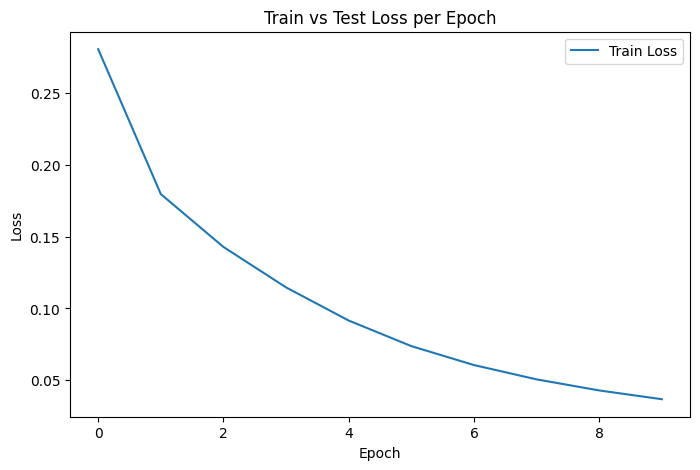

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [ ]:
test_loss = model.evaluate(dataloader_bpr_test)

In [ ]:
test_loss

1.020030519841644

In [ ]:
evaluator = Evaluate(model, test_data, interactions, k=20)

In [ ]:
evaluator.MAP_at_k()

0.06997351358585503